# YouTube Comments NLP Notebook

In [151]:
# Basics
import pandas as pd
import os
import csv
import numpy as np

## Sklearn
import sklearn # machine learning
from sklearn.feature_extraction.text import CountVectorizer # frequency counts matrix
from sklearn.model_selection import train_test_split # splitting up data
from sklearn import metrics # for accuracy/ precision
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import SGDClassifier # Support Vector Machine Classifier
# multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification)

# Dashboard/ Plotly Packages:
import plotly.dashboard_objs as dashboard
import IPython.display
from IPython.display import Image
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from pylab import *

## Read in & Clean Data
Note that we have to use encoding = "latin-1" instead of UTF-8 because we have foreign languages present
The different encodings treat characters differently (in latin-1 each character is only one byte long whereas in utf-8 it can me more than one byte in length). Typically utf-8 captures more types of characters, so it was surprising that we had to use latin-8. 
* for later: look into this more: http://www.unicode.org/reports/tr10/

In [81]:
os.chdir('/Users/andiedonovan/myProjects/Youtube/') # change directory
df = pd.read_csv('labeledCom.csv', delimiter=";", skiprows=2, encoding='latin-1', engine='python') # read in the data

In [82]:
# rename the columns
df.columns = [
  'label',
  'comment', 
  'column3'
]
df = df.drop('column3', axis = 1).dropna() # drop column 3 and missing values
print(df.head(5))

   label                                            comment
0   -1.0  Everyone knows brand's papers from.\nBut -No o...
1    0.0       ñYour paper cut balance is: \n-£25279102771î
2    1.0  OH SHIT WHEN I SAW THIS ON MY FRONT PAGE.........
3    1.0                          Blowing my mind yet again
4    0.0               Should have gone with Dunder Mifflin


## Split into Training and Test Data
Using a pre-defined train-test-split function, we randomly split the data into training data (75%) and test data (25%). We set the x variable for both to the comments, since these are the attributes we will use for classificationand the y variable to the label, as this is what we are trying to predict. The random_state paramteter is simply for reproducability (otherwise the function would produce a different split every time we ran it). 

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                        df["comment"], df["label"], 
                                        test_size=0.25, 
                                       random_state=42)

Let's make sure all of the data looks good:

In [84]:
print('lengths training variables: ', len(X_train),",", len(Y_train))
print('lengths testing variables: ', len(X_test),",", len(Y_test), '\n')

print('Are there any missing values?', 
      '\n * Training:', pd.isnull(X_train).values.any(), ',', pd.isnull(Y_train).values.any(), 
      '\n * Testing: ', pd.isnull(X_test).values.any(), ",", pd.isnull(Y_test).values.any())

lengths training variables:  820 , 820
lengths testing variables:  274 , 274 

Are there any missing values? 
 * Training: False , False 
 * Testing:  False , False


In [85]:
type(X_test) # we have a pandas core Series; we just want the comments in an array without numbering
# help(X_test) # use values attribute
# we will want to use X_test.values(), Y_train.values(), .... to just access the data in list format

pandas.core.series.Series

## Building a Model
Documentation: [Scikit-Learn Documentation]('http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#exercise-2-sentiment-analysis-on-movie-reviews')

We want to initialize a Count Vectorizer, which will convert the comments to a matrix of token (word) counts. This produces a sparse representation of the counts
We then fit the model using our training data

In [86]:
cv = CountVectorizer() 
x_train_counts = cv.fit_transform(X_train.values) # fit_transform to counts

In [87]:
type(x_train_counts) # scipy.sparse.csr.csr_matrix 

scipy.sparse.csr.csr_matrix

In [88]:
# tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_counts) # term frequency inverse document frequency matrix
# I think this is a different way of transforming our data to counts, instead of just using 'transform'

### Transform test values as well:

In [90]:
x_test_counts = cv.transform(X_test.values) # transform test data as well (but we don't need to train it since its test data!)

### Initializing the Classifier: 

In [91]:
mnb = MultinomialNB()
mnb.fit(x_train_counts, Y_train) # fit the model on the training data word counts and training data lables

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

###  Making the predictions:

In [92]:
mnb_predict = mnb.predict(x_test_counts) # make our y predictions (labels) on the comment test data

In [93]:
for i in mnb_predict[:10]:
    print (i)

-1.0
0.0
0.0
1.0
1.0
1.0
0.0
-1.0
1.0
-1.0


In [94]:
# pd.DataFrame(predicted_labels).groupby(['-1.0','0.0','1.0']).size()

### How well did we do?? (AKA accuracy metrics)

In [109]:
mnb_acc = metrics.accuracy_score(Y_test, mnb_predict)

In [110]:
print('We obtained ', round(mnb_acc, 6), '% accuracy for the model')

We obtained  0.594891 % accuracy for the model


In [111]:
np.mean(mnb_predict == Y_test)  # same score, different method

0.5948905109489051

In [98]:
print('Here is the Classification Report: \n')
print(metrics.classification_report(Y_test, mnb_predict))

Here is the Classification Report: 

             precision    recall  f1-score   support

       -1.0       0.59      0.46      0.52        83
        0.0       0.57      0.47      0.51        91
        1.0       0.61      0.82      0.70       100

avg / total       0.59      0.59      0.58       274



In [99]:
print('Here is the Confusion Matrix: \n')
metrics.confusion_matrix(Y_test, mnb_predict)

Here is the Confusion Matrix: 



array([[38, 19, 26],
       [22, 43, 26],
       [ 4, 14, 82]])

### Using a TF-IDF Transformation
* instead of just counting the number of occurences bluntly, the term frequency inverse document frequency transformation weights words based on their number of occurences in each document (aka comment) compared to occurences in the entire corpus (aka collection of comments)
* can also be used to remove stop words

In [108]:
tfidf_transformer = TfidfTransformer()
x_tfidf_tr = tfidf_transformer.fit_transform(x_train_counts)
x_tfidf_tst = tfidf_transformer.transform(x_test_counts)
mnb2 = MultinomialNB()
mnb2.fit(x_tfidf_tr, Y_train)
tfidf_pred = mnb2.predict(x_tfidf_tst)
tfidf_acc = metrics.accuracy_score(Y_test, tfidf_pred)
print('We obtained ', round(tfidf_acc, 6), '% accuracy for the tf-idf transformed model')

We obtained  0.543796 % accuracy for the tf-idf transformed model


Accuracy actually decreased! A possible explanation is that the comments are typically very short and likely to do not have many repeating words, which could have created a skewed set of weights favoring the content of long or more repetative comments (not really sure though...)

## Using the SGD (Stochastic Gradient Descent) Learning 
> "The gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance. This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM)."
[Scikit-Learn Documenttion](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)


Essentially SGD tries to find an extrema through iteration. In this case we are dealing with likelihood functions in which each algorithm tries to find the classification (positive, neutral or negative) with the highest likelihood of occuring (or probability of being correct in a sense). We want to maximize this likelihood while minimizing inaccuracies (Type I/ Type II Errors) and computational expenditure. We might have to revisit material on [Statistical Powers](https://en.wikipedia.org/wiki/Statistical_power). The count vectorizer transformation converts our data to a sparse matrix, which represents the model features (aka comments & their word counts) in matrix-form where the majority of the entries are zero. 



**Loss-Functions**: maps different events to a "cost" or price paid for inaccuracy of predictions/ classifications. Purpose is to choose the optimal loss function (aka try to minimize costly inaccuracies)

### Logistic Regression

In [106]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, max_iter=5, tol=None, random_state=1) 
sgd.fit(x_train_counts, Y_train)
sgd_predict = sgd.predict(x_test_counts)
sgd_acc = metrics.accuracy_score(Y_test, sgd_predict)
print('We obtained ', round(sgd_acc, 6), '% accuracy for the logistic regression model')

We obtained  0.638686 % accuracy for the logistic regression model


**Classifier Parameters:**
* loss parameter set to 'log' to use logistic regression
* penalty: regularization term; sparsity or feature selection
    * the process of introducing additional information in order to prevent overfitting/ sparsity overlaps: [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics))
* alpha: smoothing parameter? 
* max_iter: how many times to pass over the training data
* tol: stopping criterion; counts losses
* verbosity - using more factors than necessary; want to maximize parsimony

### Linear Support Vector Machine (SVM)

In [107]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, tol=None, random_state=1) # penalty, loss, alpha paramters
svm.fit(x_train_counts, Y_train)
svm_predict = svm.predict(x_test_counts)
svm_acc = metrics.accuracy_score(Y_test, svm_predict)
print('We obtained ', round(svm_acc, 6), '% accuracy for the SVM model')

We obtained  0.613139 % accuracy for the SVM model


We specify the loss parameter to 'hinge' to use linear SVM 

## Next Steps: 
1. Feature Engineering:
    * Look at Peter Norvig's [Spelling Corrector](http://norvig.com/spell-correct.html)
    * Meta Features, Stemming, Speech Tagging, etc.:
        * [NLP Blog Post](http://www.vikparuchuri.com/blog/natural-language-processing-tutorial/)
        * [Stanford Post](https://nlp.stanford.edu/IR-book/html/htmledition/features-for-text-1.html)
2. Try out more models; see if we can pre-process the data better?
    * Random Forests (Decision Trees), 'Ensembling' algorithms?
3. Add more videos/ comments for diversity of diction/ sentiments
4. Create a clean way of presenting results (ie with comments and their predicted classification. Maybe we can highlight the correct ones in green and the wrong ones in red?)
5. Data Visualization / Dashboard?
    * [Plotly](https://plot.ly/python/create-online-dashboard/)
    * [Tutorial](https://moderndata.plot.ly/create-a-plotly-dashboards-in-under-10-minutes/)

## Data Visualization

In [148]:
df.groupby(['label']).size()
neg_sent = df.loc[df['label'] < 0]
d1 = len(neg_sent)
d2 = len(zer_sent)
d3 = len(pos_sent)
zer_sent = df.loc[df['label'] == 0]
pos_sent = df.loc[df['label'] > 0]

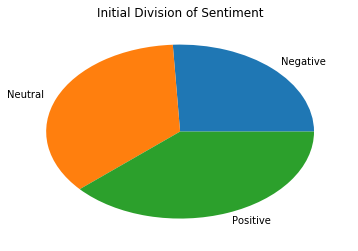

In [155]:
labels = ['Negative','Neutral', "Positive"]
values = [d1, d2, d3]
#trace = go.Figure(labels=labels, values=values)
#iplot(trace)

pie(values, labels=labels)
title('Initial Division of Sentiment')
show()

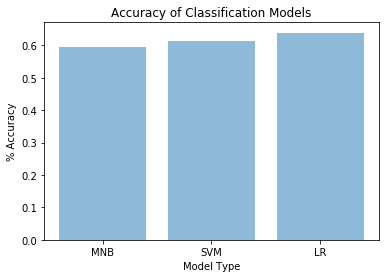

In [163]:
labels = ['MNB','SVM', "LR"]
values = [mnb_acc, svm_acc, sgd_acc]
ypos = np.arange(len(labels))

plt.bar(ypos, values, align='center', alpha=0.5)
plt.xticks(ypos, labels)
plt.ylabel('% Accuracy')
plt.xlabel('Model Type')
plt.title('Accuracy of Classification Models')
show()

## Dashboard

In [177]:
dash = dashboard.Dashboard()
PieBox = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': 'xxx',
    'title': 'pie-for-dashboard'
}
BarBox = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': 'xxx',
    'title': 'bar-for-dashboard'
}
dash.insert(PieBox)
dash.insert(BarBox, 'right', 1)

In [178]:
dash.get_preview()

In [174]:
# py.dashboard_ops.upload(dash, 'Youtube Dashboard')